In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import warnings
import re
import string
import random


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')

In [3]:
df.sample(7)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
40915,1422,Battlefield,Irrelevant,Ban for Battlefield 4 player AglyGod has occur...
50018,6186,FIFA,Irrelevant,. . . . . . . . . . -. . . . Havertz...
39730,1220,Battlefield,Negative,Battlefield 5 in 2020. WTF these plans?!
13765,8762,NBA2K,Negative,@ N2K whose genius idea was to have the right ...
18330,9942,PlayStation5(PS5),Irrelevant,Shuttin the fuck up as we play.
72085,11149,TomClancysGhostRecon,Negative,@ GhostRecon please fix the MOUNTAIN-00016 err...
64470,7845,MaddenNFL,Negative,That's why I stopped playing Madden.


In [4]:
print(f'The shape of the dataset is : {df.shape}')

The shape of the dataset is : (74681, 4)


In [5]:
print(f'The columns are :{df.columns}')

The columns are :Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')


In [6]:
print(f'The dtypes of the dataset : \n\n{df.dtypes}')

The dtypes of the dataset : 

2401                                                      int64
Borderlands                                              object
Positive                                                 object
im getting on borderlands and i will murder you all ,    object
dtype: object


In [7]:
df.describe(include='all')

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
count,74681.000000,74681,74681,73995
unique,NaN,32,4,69490
top,NaN,TomClancysRainbowSix,Negative,
freq,NaN,2400,22542,172
mean,6432.640149,NaN,NaN,NaN
std,3740.423819,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


In [8]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values , 
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

In [9]:
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.000000,0.000000,0.000000,686.000000
Missed_Values %,0.000000,0.000000,0.000000,0.009186
Duplicated values,2700.000000,2700.000000,2700.000000,2700.000000
Duplicated values %,0.036154,0.036154,0.036154,0.036154


In [10]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


In [11]:
df.rename(columns={'2401' : 'Index' , 'Borderlands': 'Land' , 'Positive' : 'Mode' 
                   , "im getting on borderlands and i will murder you all ,": 'Text'}, inplace=True)

In [12]:
df.columns

Index(['Index', 'Land', 'Mode', 'Text'], dtype='object')

In [13]:
print(f'The number of unique lands : {len(df.Land.unique())}')
print('**' * 40)
df.Land.unique()

The number of unique lands : 32
********************************************************************************


array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [14]:
lands =df.Land.value_counts()
lands.to_frame()

,count
Land,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
Microsoft,2304
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291


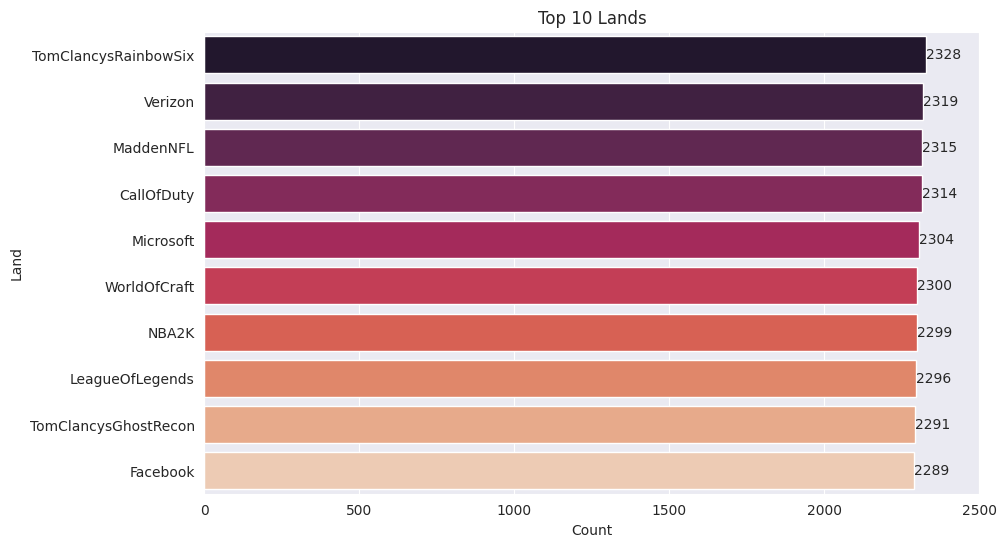

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
bar = sns.barplot(x=lands.values[:10] ,y=lands.index[:10] , palette='rocket')
bar.bar_label(bar.containers[0])
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.xlim(0 , 2500)
plt.show()

In [16]:
print(f'The unique values of Mode : {len(df.Mode.unique())}')
print('**' * 20)
print(df.Mode.unique())

The unique values of Mode : 4
****************************************
['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [17]:
mode = df.Mode.value_counts()
mode.to_frame().T

Mode,Negative,Positive,Neutral,Irrelevant
count,21698,19712,17708,12537




Negative : 30.3 % <br>
Positive : 27.5%<br>
Neutral : 24.7%<br>
Irrelevant : 17.5%<br>


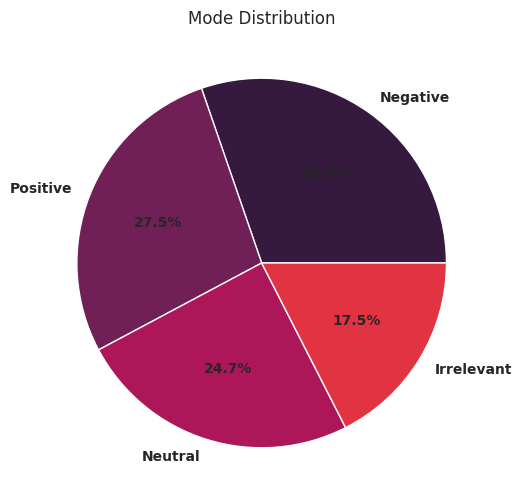

In [18]:
plt.figure(figsize=(6,6))
plt.pie(x = mode.values , labels=mode.keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"},colors=sns.color_palette("rocket"))
plt.title('Mode Distribution') 
plt.show()

In [19]:
pd.crosstab(df.Mode , df.Land).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Irrelevant'] , cmap='BuGn')


Mode,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,971
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


In [20]:
def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols 
                           u"\U0001F680-\U0001F6FF"  # transport 
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', tx)
def text_cleaner(tx):
    
    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    
    return text


In [21]:
random.seed(99)
test_text =text_cleaner( random.choice(df['Text']))
test_text = clean_emoji(test_text)
test_text

'ghost of tsushima is now graphically the best open world. red dead redemption 2 is one second ahead.'

POS => Part Of Speech

In [22]:
doc = nlp(test_text)
for token in doc :
    print(f'{token} => {token.pos_}')

ghost => NOUN
of => ADP
tsushima => PROPN
is => AUX
now => ADV
graphically => ADV
the => DET
best => ADV
open => ADJ
world => NOUN
. => PUNCT
red => ADJ
dead => ADJ
redemption => NOUN
2 => NUM
is => AUX
one => NUM
second => ADJ
ahead => ADV
. => PUNCT


Named Entity Recognition

In [23]:
doc = nlp(test_text)
for chunk in doc.ents:
    print(f'{chunk} => {chunk.label_}')


tsushima => GPE
2 => CARDINAL
second => ORDINAL


In [24]:
doc = nlp(test_text)
for chunk in doc.noun_chunks:
    print(f'{chunk} => {chunk.label_}')

ghost => NP
tsushima => NP
the best open world => NP
red dead redemption => NP


In [25]:
# Tokenizer = TweetTokenizer()
Tokenizer=RegexpTokenizer(r'\w+')
test_text_tokenized = Tokenizer.tokenize(test_text)
test_text_tokenized

# df['Text']=df['Text'].apply(lambda x : Tokenizer.tokenize(x))

['ghost',
 'of',
 'tsushima',
 'is',
 'now',
 'graphically',
 'the',
 'best',
 'open',
 'world',
 'red',
 'dead',
 'redemption',
 '2',
 'is',
 'one',
 'second',
 'ahead']

 Counter vectorizer

array([[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

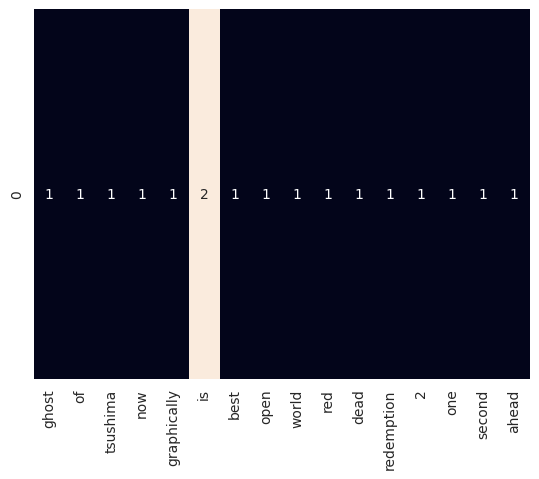

In [26]:

words  = ['ghost','of','tsushima','now','graphically','is','best','open','world','red','dead','redemption','2','one','second','ahead']
counter_vectorizer = CountVectorizer()
transform = counter_vectorizer.fit_transform([test_text]).toarray()
sns.heatmap(transform, annot=True,xticklabels=words, 
        cbar=False)
transform

array([[0.22941573, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.45883147, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.22941573, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.22941573]])

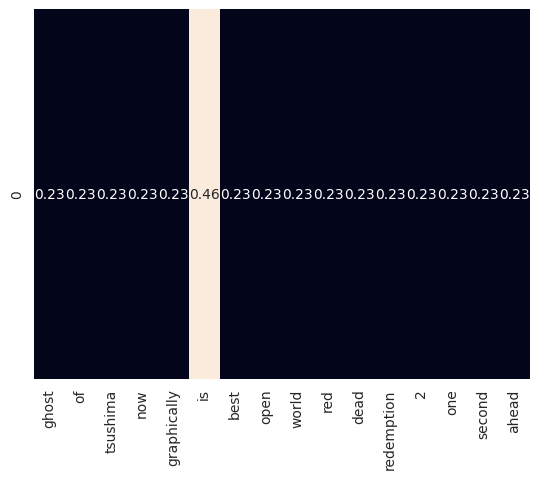

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
words  = ['ghost','of','tsushima','now','graphically','is','best','open','world','red','dead','redemption','2','one','second','ahead']
TF_IDF = TfidfVectorizer()
transform = TF_IDF.fit_transform([test_text]).toarray()
sns.heatmap(transform, annot=True,xticklabels=words, 
        cbar=False)
transform

N-grams => 3-grams 

In [29]:
def n_grams(text, n):

    return [text[i:i+n] for i in range(len(text)-n+1)]
cleaned = test_text_tokenized
n_grams(cleaned, 3)


[['ghost', 'of', 'tsushima'],
 ['of', 'tsushima', 'is'],
 ['tsushima', 'is', 'now'],
 ['is', 'now', 'graphically'],
 ['now', 'graphically', 'the'],
 ['graphically', 'the', 'best'],
 ['the', 'best', 'open'],
 ['best', 'open', 'world'],
 ['open', 'world', 'red'],
 ['world', 'red', 'dead'],
 ['red', 'dead', 'redemption'],
 ['dead', 'redemption', '2'],
 ['redemption', '2', 'is'],
 ['2', 'is', 'one'],
 ['is', 'one', 'second'],
 ['one', 'second', 'ahead']]

In [30]:
stopwords_list = stopwords.words('english')
print(f'There are {len(stopwords_list) } stop words')
print('**' * 20 , '\n20 of them are as follows:\n')
for inx , value in enumerate(stopwords_list[:20]):
    print(f'{inx+1}:{value}')


There are 179 stop words
**************************************** 
20 of them are as follows:

1:i
2:me
3:my
4:myself
5:we
6:our
7:ours
8:ourselves
9:you
10:you're
11:you've
12:you'll
13:you'd
14:your
15:yours
16:yourself
17:yourselves
18:he
19:him
20:his


In [31]:
def make_corpus(kind):
    corpus = []
    for text in df.loc[df['Mode']==kind]['Text'].str.split():
        for word in text:
            corpus.append(word)
    return corpus

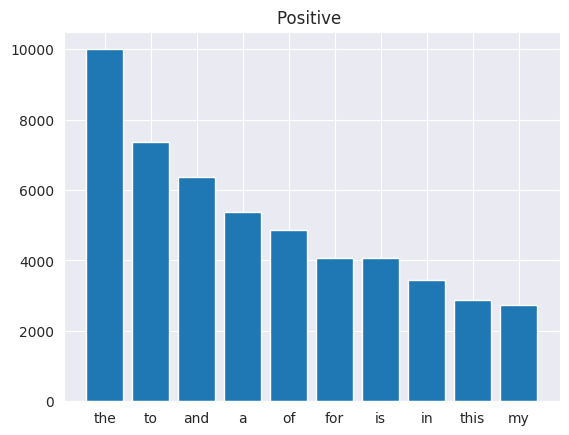

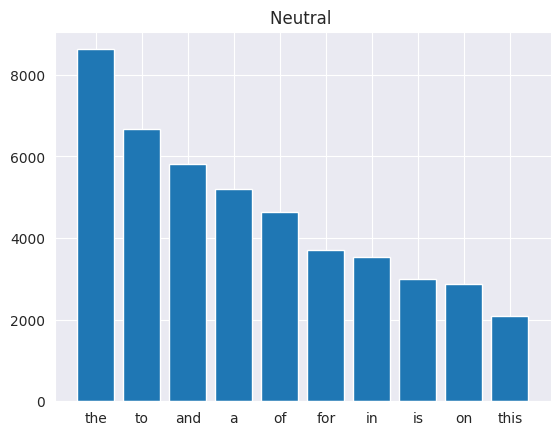

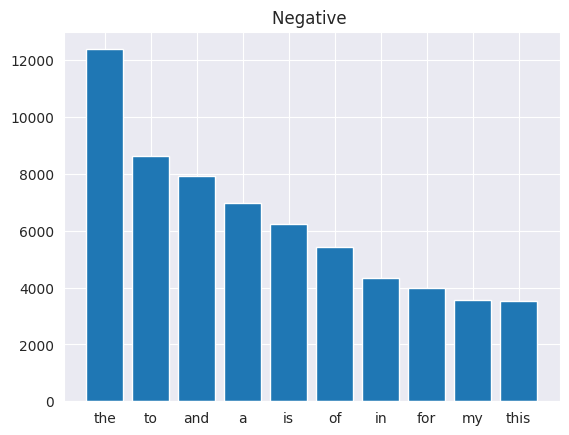

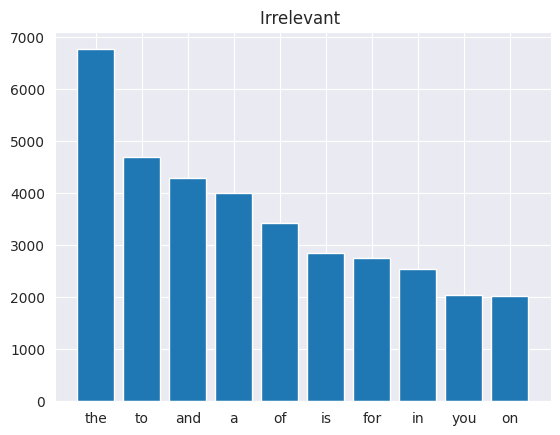

CPU times: user 5.2 s, sys: 644 ms, total: 5.84 s
Wall time: 4.76 s


In [32]:
%%time
stop = stopwords.words('english')
sentiments = list(df.Mode.unique())



for inx , value in enumerate(sentiments):
    
    corpus = make_corpus(value)
    
    dic = defaultdict(int)

    for word in corpus:
        if word in stop:
            dic[word] += 1
    
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

    x, y = zip(*top)
    plt.title(f'{value} ')
    plt.bar(x , y)
    plt.show()

In [33]:
# df['Text'] = df['Text'].apply(lambda x : clean_emoji(x))
df['Text'] = df['Text'].apply(lambda x : text_cleaner(x))
df['Text']= df['Text'].apply(lambda x : Tokenizer.tokenize(x))
df['Text'].to_frame()


,Text
0,"[i, am, coming, to, the, borders, and, i, will..."
1,"[im, getting, on, borderlands, and, i, will, k..."
2,"[im, coming, on, borderlands, and, i, will, mu..."
3,"[im, getting, on, borderlands, 2, and, i, will..."
4,"[im, getting, into, borderlands, and, i, can, ..."
...,...
74676,"[just, realized, that, the, windows, partition..."
74677,"[just, realized, that, my, mac, window, partit..."
74678,"[just, realized, the, windows, partition, of, ..."
74679,"[just, realized, between, the, windows, partit..."


Lemmas and Stems

In [35]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(test_text)
for token in doc :
    print(f'{token} => {token.lemma_}')

ghost => ghost
of => of
tsushima => tsushima
is => be
now => now
graphically => graphically
the => the
best => well
open => open
world => world
. => .
red => red
dead => dead
redemption => redemption
2 => 2
is => be
one => one
second => second
ahead => ahead
. => .


In [36]:
# lemmatizer = WordNetLemmatizer() 
Stemmer = PorterStemmer()
def stopwords_cleaner(text):
#     word = [lemmatizer.lemmatize(letter) for letter in text if letter not in stopwords_list]
    word = [Stemmer.stem(letter) for letter in text if letter not in stopwords_list]
    peasting = ' '.join(word)
    return peasting
df['Text'] = df['Text'].apply(lambda x : stopwords_cleaner(x))
# stopwords_cleaner(Tokenizer.tokenize(df.Text[100]))

In [ ]:
df['Text'][:10].to_frame()



**WordCloud**


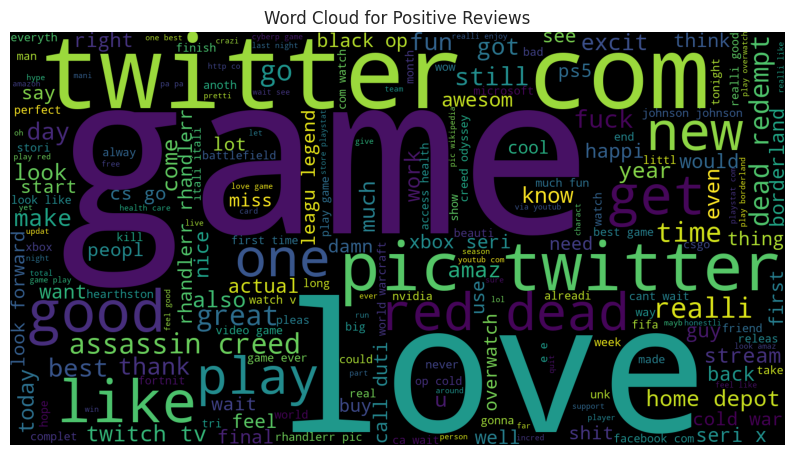

CPU times: user 3.44 s, sys: 248 ms, total: 3.69 s
Wall time: 3.42 s


In [37]:
%%time
positive_reviews = df[df['Mode'] == 'Positive']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()


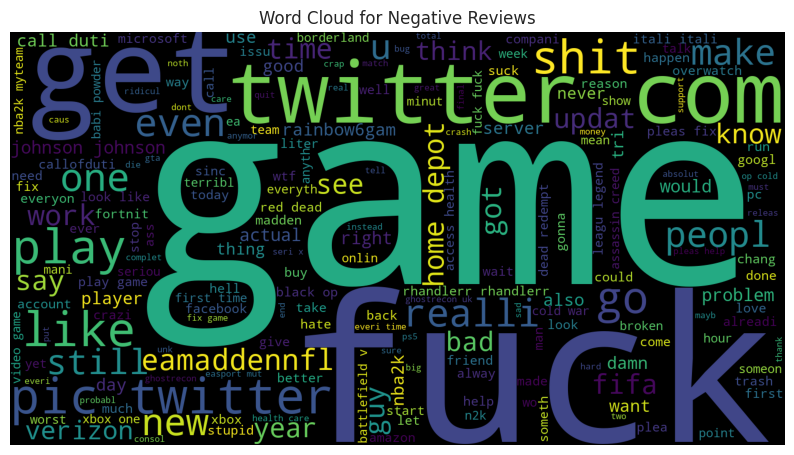

CPU times: user 3.85 s, sys: 252 ms, total: 4.1 s
Wall time: 3.83 s


In [38]:
%%time
positive_reviews = df[df['Mode'] == 'Negative']['Text']
neg = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(neg)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

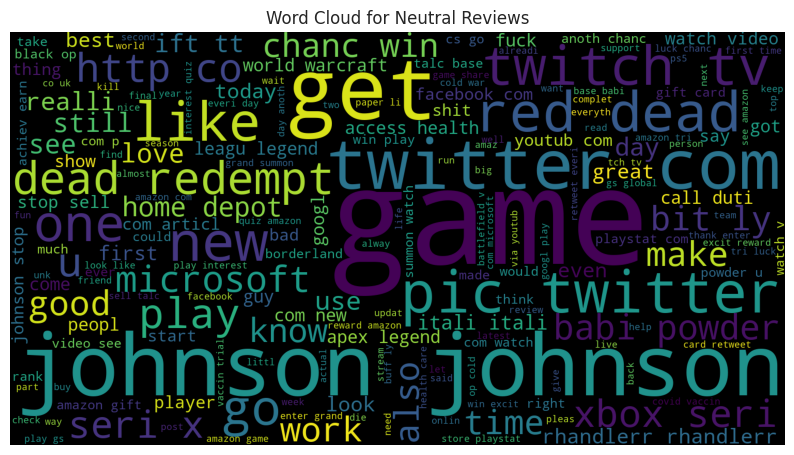

CPU times: user 3.57 s, sys: 248 ms, total: 3.82 s
Wall time: 3.55 s


In [39]:
%%time
positive_reviews = df[df['Mode'] == 'Neutral']['Text']
Neutral = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Neutral)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Neutral Reviews')
plt.axis('off')
plt.show()

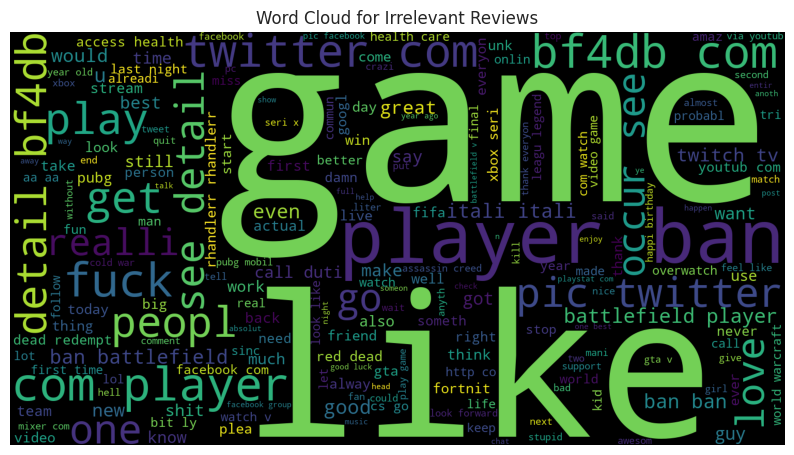

CPU times: user 3.14 s, sys: 212 ms, total: 3.36 s
Wall time: 3.09 s


In [40]:
%%time
positive_reviews = df[df['Mode'] == 'Irrelevant']['Text']
Irrelevant  = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Irrelevant )
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Irrelevant Reviews')
plt.axis('off')
plt.show()


In [41]:
len_text = [len(tx) for tx in df['Text'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')


Max Length : 797
Min Length : 0
Mean Length : 67.68
Std Length : 49.01
Mew + 2sigma : 165.7


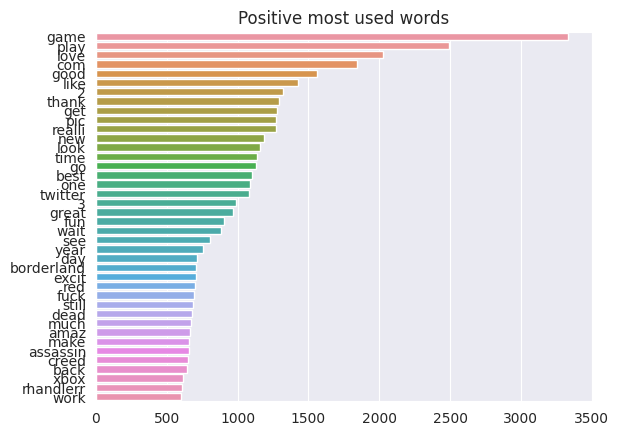

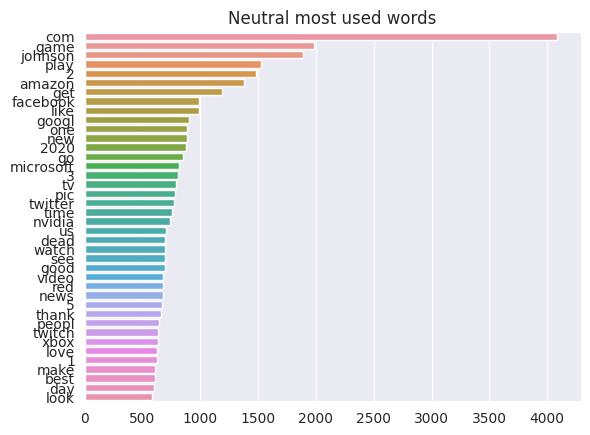

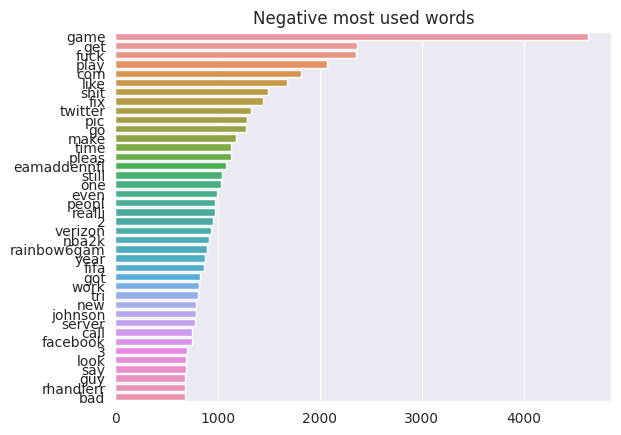

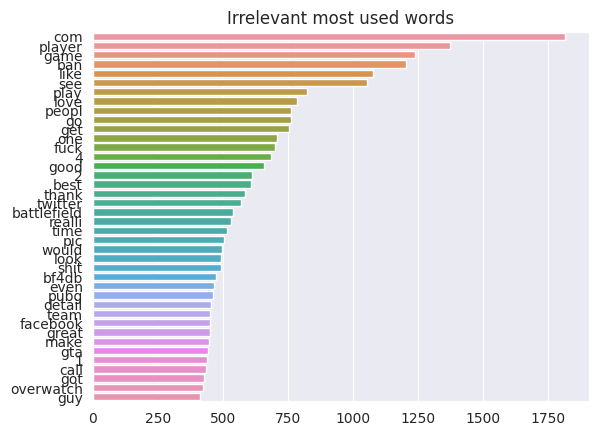

CPU times: user 3.36 s, sys: 626 ms, total: 3.99 s
Wall time: 2.91 s


In [42]:
%%time
for inx , value in enumerate(sentiments):
    
    counter = Counter(make_corpus(value))
    most_common = counter.most_common()

    x = []
    y = []

    for word, count in most_common[:40]:
         if word not in stop:
            x.append(word)
            y.append(count)
         
    sns.barplot(x=y, y=x, orient='h')
    plt.title(f'{value} most used words')
    plt.show()

In [43]:
df['sentiments'] = df['Mode'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [44]:
df.sample(10)

,Index,Land,Mode,Text,sentiments
55922,2399,CallOfDuty,Negative,hate day duti updat,0
10093,12938,Xbox(Xseries),Negative,microsoft cours could better job demonstr game...,0
44683,11674,Verizon,Irrelevant,cap af mf blank everywher,2
43775,10316,PlayerUnknownsBattlegrounds(PUBG),Irrelevant,,2
55371,2307,CallOfDuty,Neutral,bad callofduti fix thank unk made good,2
37823,5285,Hearthstone,Negative,greedi,0
63475,7679,MaddenNFL,Negative,eamaddennfl anyon speed even matter idk tyreek...,0
20681,12742,WorldOfCraft,Negative,hey blizzardc atvi ab warcraft holinka watcher...,0
68300,3696,Cyberpunk2077,Positive,pre order mine yesterday still worth,1
14358,2861,Dota2,Irrelevant,og player realli broke stereotyp player,2


In [45]:
class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }

In [46]:
def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])
        
    return data

In [47]:
def create_embedding_matrix(word_index,embedding_dict):

    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
            
    return embedding_matrix

In [48]:
class sentimentBiLSTM(nn.Module):
#inherited from nn.Module
    
    def __init__(self, embedding_matrix, hidden_dim, output_size):
      
        #initializing the params by initialization method 
        super(sentimentBiLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]
        # craetinh embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words,embedding_dim=embed_dim)
        
        ## initializes the weights of the embedding layer to the pretrained embeddings in 
        ## embedding_matrix. It first converts embedding_matrix to a PyTorch tensor and 
        ## wraps it in an nn.Parameter object, which makes it a learnable parameter of the model.
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_dim,hidden_dim,bidirectional=True,batch_first=True)

        #it is multuplied by 2 becuase it is bi_directional if one-sided it didnt need.
        self.fc = nn.Linear(hidden_dim*2, output_size)
        

    #we need a forward function to model calculate the cost and know how bad the params is .  
    # However , it can be written in a line of code but if we want to track it it is easier way.  
    def forward(self, x):

       
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out[:, -1]
        out = self.fc(lstm_out)

        return out

In [49]:
y = df.sentiments.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)

In [50]:
MAX_LEN = 167
BATCH_SIZE = 32
hidden_dim = 64
output_size = 3


if torch.cuda.is_available():
    
       device = torch.device("cuda")
   
else:
       device = torch.device("cpu")
    

print(f'Current device is {device}')


Current device is cuda


In [51]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.Text.values.tolist())

xtrain = tokenizer.texts_to_sequences(train_df.Text.values)
xtest = tokenizer.texts_to_sequences(test_df.Text.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)
train_dataset = Dataset(text=xtrain,sentiment=train_df.sentiments.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True)
valid_dataset = Dataset(text=xtest,sentiment=test_df.sentiments.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,drop_last=True)


In [52]:
# check a batch of data 
one_batch = next(iter(train_loader))
one_batch

{'text': tensor([[    0,     0,     0,  ...,     0,    41,    12],
         [    0,     0,     0,  ...,     0,   996,   659],
         [    0,     0,     0,  ...,   195,   143, 20585],
         ...,
         [    0,     0,     0,  ...,   220,     6,   257],
         [    0,     0,     0,  ...,  1929,  2875,    89],
         [    0,     0,     0,  ...,     1,   707,   357]]),
 'target': tensor([1, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0,
         1, 0, 1, 2, 0, 2, 0, 2])}

In [53]:
embedding_dict = load_vectors('/kaggle/input/glove6b300dtxt/glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)

In [54]:
model = sentimentBiLSTM(embedding_matrix ,  hidden_dim, output_size)
model = model.to(device)
print(model)

sentimentBiLSTM(
  (embedding): Embedding(23595, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [55]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss() 
# schedul_learning = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer , milestones=[6] ,
#                                                         gamma=0.055)

def acc(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label.squeeze()).item()

In [56]:
clip = 5
epochs = 9
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    # for getting loss and accuracy for train
    train_losses = []
    train_acc = 0.0

    #put model on train mode
    model.train()
    correct = 0

    # initialize hidden state 
    for data in train_loader:  

        #get text and target 
        inputs = data['text']
        labels = data['target']

        #put them on GPU and right dtypes
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

         #gradient becomes zero=> avoid accumulating 
        model.zero_grad()
        output = model(inputs)
          # calculate the loss and perform backprop
        loss = criterion(output, labels.long())
        loss.backward()
        train_losses.append(loss.item())
        # accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in LSTMs
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    # for getting loss and accuracy for valiadtion
    val_losses = []
    val_acc = 0.0

    #put model on evaluation mode
    model.eval()
    for data in valid_loader:

        #get text and target 
        inputs = data['text']
        labels = data['target']

        #put them on GPU and right dtypes
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

        #gradient becomes zero=> avoid accumulating 
        model.zero_grad()
        output = model(inputs)

        output = model(inputs)
        #Loss calculating 
        val_loss = criterion(output, labels.long())
        #append Loss to the above list
        val_losses.append(val_loss.item())

        # calculating accuracy 
        accuracy = acc(output,labels)
        val_acc += accuracy
        epoch_train_loss = np.mean(train_losses)

        #using schedule lr if you need
#         schedul_learning.step()
#         schedul_learning

    #appending all accuracy and loss to the above lists and variables
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        #each time that model(params) get better you can save the model(you have to enter a path ou you pc and save with pt file)
        # torch.save(model.state_dict(), r'C:\Users\payama\Desktop\Projects kaggle\NLP\vectors features\BidirectionalLSTM.pt')
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        print(f'Validation loss decreased ({valid_loss_min} --> {epoch_val_loss})  Saving model ...')
        # save model if better result happends
        valid_loss_min = epoch_val_loss
    print(30 * '==' , '>')

Epoch 1
train_loss : 0.8599330556752095 val_loss : 0.7802575789308654
train_accuracy : 59.592840694996866 val_accuracy : 64.54539111018073
Validation loss decreased (inf --> 0.7802575789308654)  Saving model ...
============================================================ >
Epoch 2
train_loss : 0.6719036659902864 val_loss : 0.67320950105953
train_accuracy : 70.77838252738819 val_accuracy : 70.23236340799664
Validation loss decreased (0.7802575789308654 --> 0.67320950105953)  Saving model ...
============================================================ >
Epoch 3
train_loss : 0.5202268070428482 val_loss : 0.5855836697606166
train_accuracy : 78.27611471634917 val_accuracy : 75.49368501849139
Validation loss decreased (0.67320950105953 --> 0.5855836697606166)  Saving model ...
============================================================ >
Epoch 4
train_loss : 0.4102739819529867 val_loss : 0.5356822546563159
train_accuracy : 83.28797711255321 val_accuracy : 78.54301863093993
Validation loss

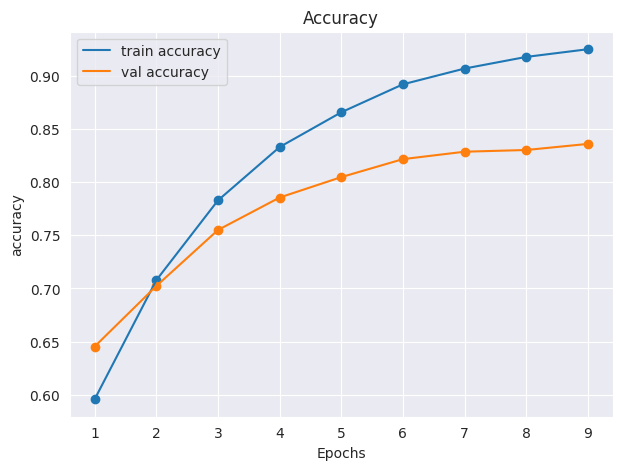

In [57]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_acc , label='train accuracy')
plt.scatter(range(1,10),epoch_tr_acc)
plt.plot(range(1,10),epoch_vl_acc , label='val accuracy')
plt.scatter(range(1,10),epoch_vl_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

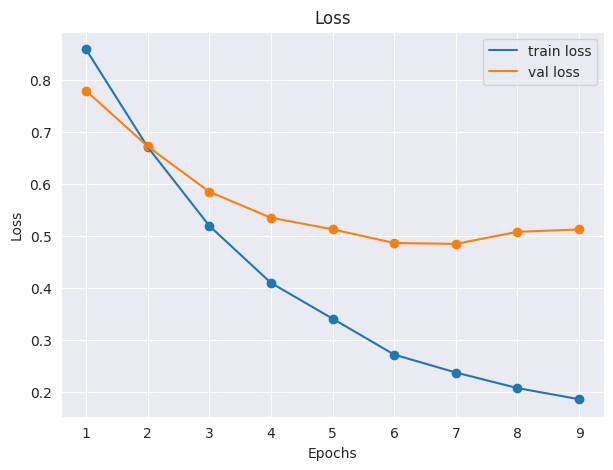

In [58]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_loss , label='train loss')
plt.scatter(range(1,10),epoch_tr_loss )
plt.plot(range(1,10),epoch_vl_loss , label='val loss')
plt.scatter(range(1,10),epoch_vl_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()